In [1]:
import cv2
import os
import numpy as np
from skimage.filters import threshold_otsu
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
def create_brain_mask(image, threshold_factor=0.1):
    """Create mask for brain region using adaptive thresholding"""
    # Simple thresholding (adjust factor based on your images)
    thresh = threshold_factor * np.max(image)
    mask = image > thresh
    
    # Clean up mask with morphological operations
    kernel = np.ones((3,3), np.uint8)
    mask = cv2.morphologyEx(mask.astype(np.uint8), cv2.MORPH_CLOSE, kernel)
    
    return mask.astype(bool)

def compute_reference_landmarks(input_dir, num_samples_per_class=20, num_landmarks=15):
    """Compute reference landmarks using only brain tissue"""
    percentiles = np.linspace(5, 95, num_landmarks)
    all_percentiles = []

    for class_dir in os.listdir(input_dir):
        class_path = os.path.join(input_dir, class_dir)
        if not os.path.isdir(class_path):
            continue

        images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg'))]
        num_samples = min(num_samples_per_class, len(images))
        
        for img_name in np.random.choice(images, num_samples, replace=False):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                mask = create_brain_mask(img)
                if np.sum(mask) == 0:  # Skip images with empty masks
                    continue
                
                brain_pixels = img[mask]
                brain_norm = (brain_pixels - brain_pixels.min()) / \
                            (brain_pixels.max() - brain_pixels.min() + 1e-8)
                
                perc = np.percentile(brain_norm, percentiles)
                all_percentiles.append(perc)

    return np.mean(all_percentiles, axis=0)

def nyul_normalize(image, reference_landmarks, percentiles):
    """Apply normalization only to brain region"""
    # Create brain mask
    mask = create_brain_mask(image)
    if np.sum(mask) == 0:  # Return original if no brain detected
        return image
    
    # Process only brain region
    brain_pixels = image[mask]
    brain_norm = (brain_pixels - brain_pixels.min()) / \
                (brain_pixels.max() - brain_pixels.min() + 1e-8)
    
    # Calculate percentiles on brain tissue only
    img_percentiles = np.percentile(brain_norm, percentiles)
    
    # Add boundary points
    img_perc = np.concatenate(([0], img_percentiles, [1]))
    ref_landmarks = np.concatenate(([0], reference_landmarks, [1]))
    
    # Create mapping
    mapped_pixels = np.interp(brain_norm.flatten(), img_perc, ref_landmarks)
    
    # Reconstruct image
    normalized = np.zeros_like(image, dtype=np.float32)
    normalized[mask] = mapped_pixels
    
    # Rescale and maintain background as black
    normalized = np.clip(normalized * 255, 0, 255).astype(np.uint8)
    normalized[~mask] = 0  # Force background to pure black
    
    return normalized

# Keep the rest of the process_dataset function from previous implementation

def process_dataset(input_dir, output_dir, landmarks_path=None, 
                    num_samples_per_class=20, num_landmarks=15):
    """Process dataset with Nyul normalization preserving directory structure"""
    os.makedirs(output_dir, exist_ok=True)
    
    # Define percentiles (match compute_reference_landmarks)
    percentiles = np.linspace(5, 95, num_landmarks)
    
    # Load or compute reference landmarks
    if landmarks_path and os.path.exists(landmarks_path):
        with open(landmarks_path, 'rb') as f:
            reference_landmarks = pickle.load(f)
        print(f"Loaded reference landmarks from {landmarks_path}")
    else:
        print("Computing new reference landmarks...")
        reference_landmarks = compute_reference_landmarks(
            input_dir, num_samples_per_class, num_landmarks
        )
        if landmarks_path:
            with open(landmarks_path, 'wb') as f:
                pickle.dump(reference_landmarks, f)
            print(f"Saved reference landmarks to {landmarks_path}")

    # Process all images
    for class_dir in os.listdir(input_dir):
        class_path = os.path.join(input_dir, class_dir)
        output_class_path = os.path.join(output_dir, class_dir)
        os.makedirs(output_class_path, exist_ok=True)

        for file_name in tqdm(os.listdir(class_path), desc=f"Processing: {class_path}"):
            input_path = os.path.join(class_path, file_name)
            output_path = os.path.join(output_class_path, file_name)
            
            try:
                img = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
                if img is not None:
                    normalized = nyul_normalize(img, reference_landmarks, percentiles)
                    cv2.imwrite(output_path, normalized)
                else:
                    print(f"Warning: Could not read {input_path}")
            except Exception as e:
                print(f"Error processing {input_path}: {str(e)}")


In [4]:
process_dataset(input_dir= "Brain tumor_D2_Original",
                output_dir= "Brain tumor_D2_Nyul Normalization",
                landmarks_path="reference_landmarks.pkl",
                num_samples_per_class=20,
                num_landmarks=15)

Computing new reference landmarks...
Saved reference landmarks to reference_landmarks.pkl


Processing: Brain tumor_D2_Original\pituitary: 100%|██████████| 300/300 [00:05<00:00, 53.92it/s]


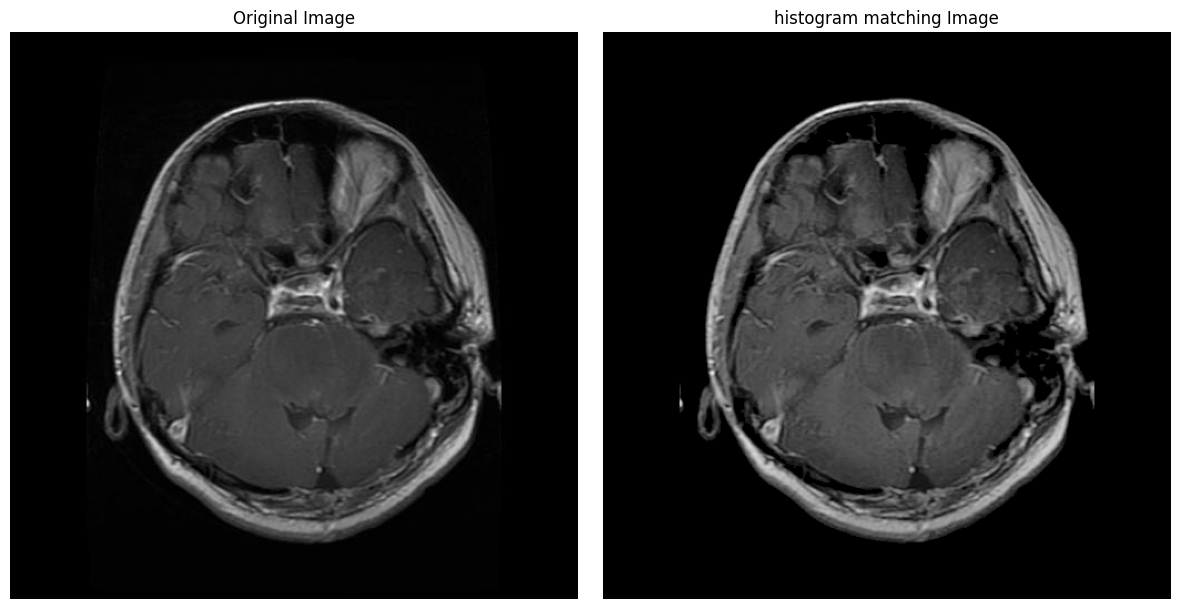

In [5]:
image_path = 'Brain tumor_D2_Original\glioma\Te-gl_0010.jpg'
with open("reference_landmarks.pkl", 'rb') as f:
    reference_landmarks = pickle.load(f)

img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
percentiles = np.linspace(5, 95, 15)
corrected_image =  nyul_normalize(img, reference_landmarks, percentiles)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(corrected_image, cmap='gray')
plt.title('histogram matching Image')
plt.axis('off')
plt.tight_layout()
plt.show()